In [1]:
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

Using TensorFlow backend.
c:\users\kapil\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
c:\users\kapil\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
c:\users\kapil\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [12]:
p = Path("Dataset")
dirs = p.glob("*")
 
imagesData = []
labels = []

labelsDict = {"Pikachu":0,"Bulbasaur":1,"Meowth":2}
label2Pokemon = {0:"Pikachu",1:"Bulbasaur",2:"Meowth"}

for folders in dirs:
    label = str(folders).split("\\")[-1]
    cnt = 0
    print(folders)
    for imagePath in folders.glob("*.jpg"):
        img = image.load_img(imagePath,target_size=(100,100))
        imgArr = image.img_to_array(img)
        imagesData.append(imgArr)
        labels.append(labelsDict[label])
        cnt += 1
    print(cnt)

Dataset\Bulbasaur
173
Dataset\Meowth
70
Dataset\Pikachu
199


In [14]:
X = np.array(imagesData)
Y = np.array(labels)
print(X.shape,Y.shape)

(442, 100, 100, 3) (442,)


In [19]:
def drawImg(img,label):
    plt.title(label2Pokemon[label])
    plt.imshow(img)
    plt.show()

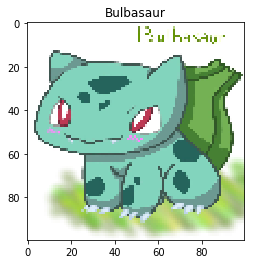

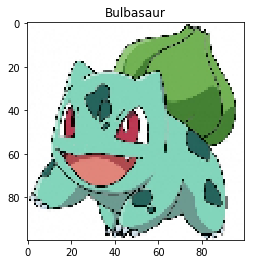

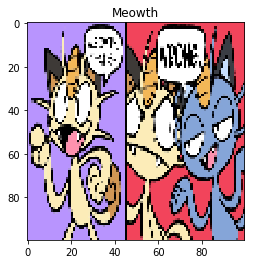

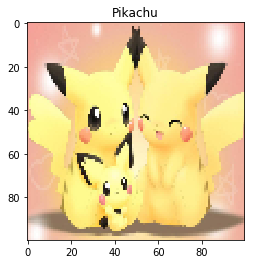

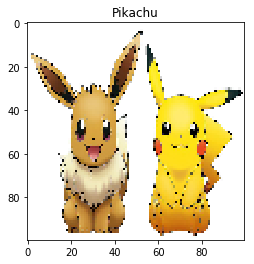

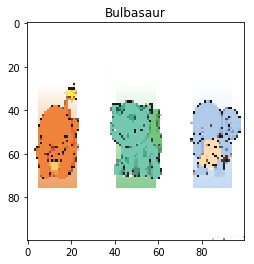

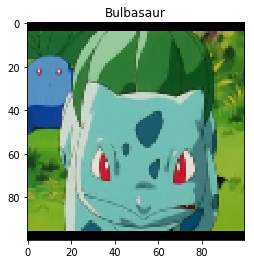

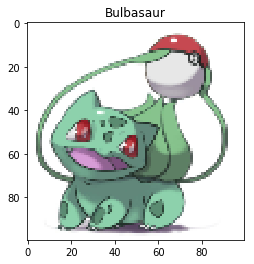

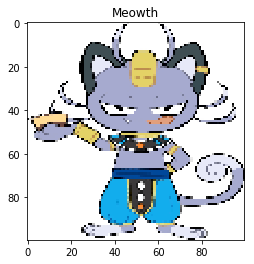

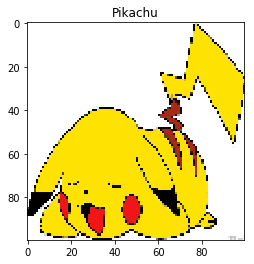

In [23]:
for i in range(10):
    r = np.random.randint(400)
    drawImg(X[r]/255.0,Y[r])